In [1]:
import numpy as np
import pickle
import time
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from datetime import datetime

In [2]:
start_run = 11
end_run = 11

output_file_name = 'Run11_list.pkl'
boards = 3

In [3]:
Tstamp_us = []
Brd = []
Ch = []
LG = []
HG = []
runNum = []

file_start_time = None

for run_number in range(start_run, end_run+1):
    input_file_name = f"Run{run_number}_list.txt"

    with open(input_file_name) as f:
        lines = f.read().split('\n')

    last_tstamp = 0  # Initialize last timestamp for continuity across files

    for i, line in enumerate(lines):
        if i == 6:  # Line containing the start time
            start_time_str = ' '.join(line.split()[4:-1])  # Extract start time string, excluding "UTC"
            file_start_time = datetime.strptime(start_time_str, "%a %b %d %H:%M:%S %Y")
            file_start_time = file_start_time.timestamp() * 1e6  # Convert to microseconds
        elif i > 8:
            data = line.split()

            if len(data) == 6:
                Tstamp_us.append(float(data[0]) + file_start_time)
                last_tstamp = float(data[0]) + file_start_time
                Brd.append(int(data[2]))
                Ch.append(int(data[3]))
                LG.append(int(data[4]))
                HG.append(int(data[5]))
                runNum.append(run_number)
            elif len(data) == 4:
                if last_tstamp is not None:
                    Tstamp_us.append(last_tstamp)
                Brd.append(int(data[0]))
                Ch.append(int(data[1]))
                LG.append(int(data[2]))
                HG.append(int(data[3]))
                runNum.append(run_number)

# Convert timestamps to datetime objects
Tstamp_utc = [datetime.utcfromtimestamp(tstamp_us / 1e6) for tstamp_us in Tstamp_us]


In [4]:
window_size = 100
current_event_id = 1
current_timestamp = Tstamp_us[0]
event_ids = []
for timestamp in Tstamp_us:
    if timestamp - current_timestamp <= window_size:
        event_ids.append(current_event_id)
    else:
        current_event_id += 1
        event_ids.append(current_event_id)
        current_timestamp = timestamp
        
event_counts = Counter(event_ids)
mask = [event_counts[event_id] == (boards*64) for event_id in event_ids]

In [5]:
Brd = [value for i, value in enumerate(Brd) if mask[i]]
Ch = [value for i, value in enumerate(Ch) if mask[i]]
LG = [value for i, value in enumerate(LG) if mask[i]]
HG = [value for i, value in enumerate(HG) if mask[i]]
Tstamp_us = [value for i, value in enumerate(Tstamp_us) if mask[i]]
Tstamp_utc = [value for i, value in enumerate(Tstamp_utc) if mask[i]]
event_ids = [value for i, value in enumerate(event_ids) if mask[i]]

In [6]:
events = pd.DataFrame({
    'Brd': Brd,
    'Ch': Ch,
    'LG': LG,
    'HG': HG,
    'Tstamp_us': Tstamp_us,
    'Tstamp_utc': Tstamp_utc,
    'event_ids': event_ids
})

In [7]:
with open(output_file_name, 'wb') as handle:
    pickle.dump(events, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
def get_LG_values(board_number, channel_number, events):

    # Filter events DataFrame based on board number and channel number
    filtered_events = events[(events['Brd'] == board_number) & (events['Ch'] == channel_number)]
    
    # Retrieve LG values from filtered events
    LG_values = filtered_events['LG'].tolist()

    
    return LG_values

def plot_histograms(board_number, events):
    # Create subplots for each channel
    fig, axs = plt.subplots(8, 8, figsize=(16, 16),sharey=True,sharex=True)
    fig.suptitle(f'Board {board_number} ', fontsize=20, y = 1)
    plt.rcParams['figure.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['savefig.bbox']='tight'
    
    
    for i in range(8):
        for j in range(8):
            channel_number = i * 8 + j
            LG_values = get_LG_values(board_number, channel_number, events)
            
            # Create histogram
            h, bins = np.histogram(LG_values, bins=50, range=(0, 1005))
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            errors = np.sqrt(h)
            
            # Plot error bar plot
            axs[i, j].errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)
        
            axs[i, j].set_title(f'Channel {channel_number}', fontsize = 10, pad=-15, loc='center')
            
            axs[i, j].set_yscale("log") 
            
            # Set labels
            if i == 7:  # Bottom most row
                axs[i, j].set_xlabel('Value [ADC]', fontsize = 10)
            if j == 0:  # Left most column
                axs[i, j].set_ylabel('Count', fontsize = 10)

    # Adjust layout   
    plt.tight_layout(pad=0.0)
    plt.subplots_adjust(hspace=0.0, wspace=0.0)
 
    plt.show()

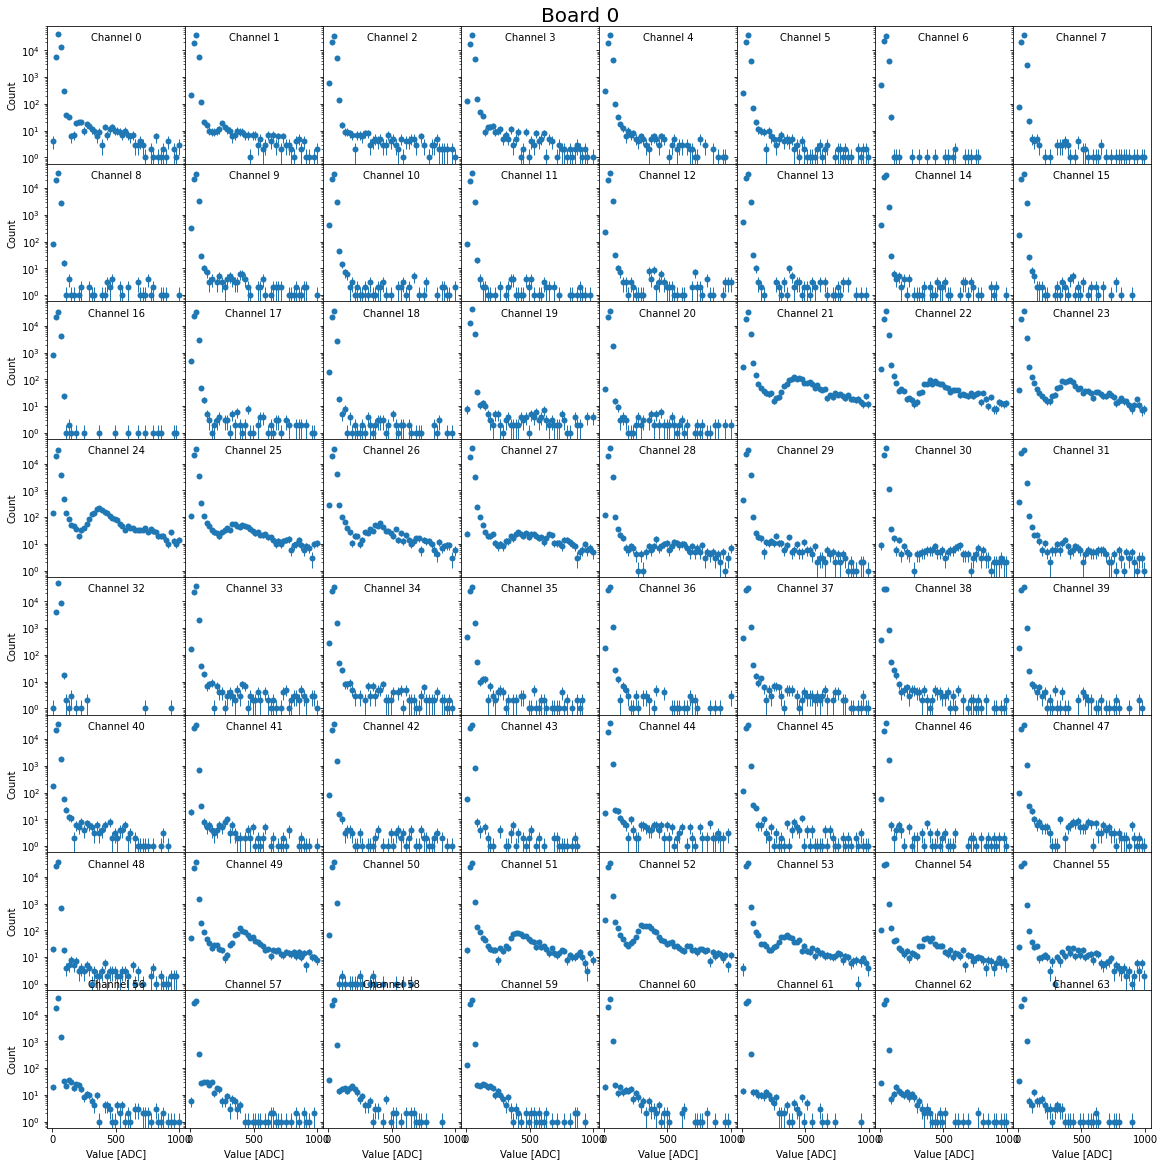

In [9]:
plot_histograms(0, events)

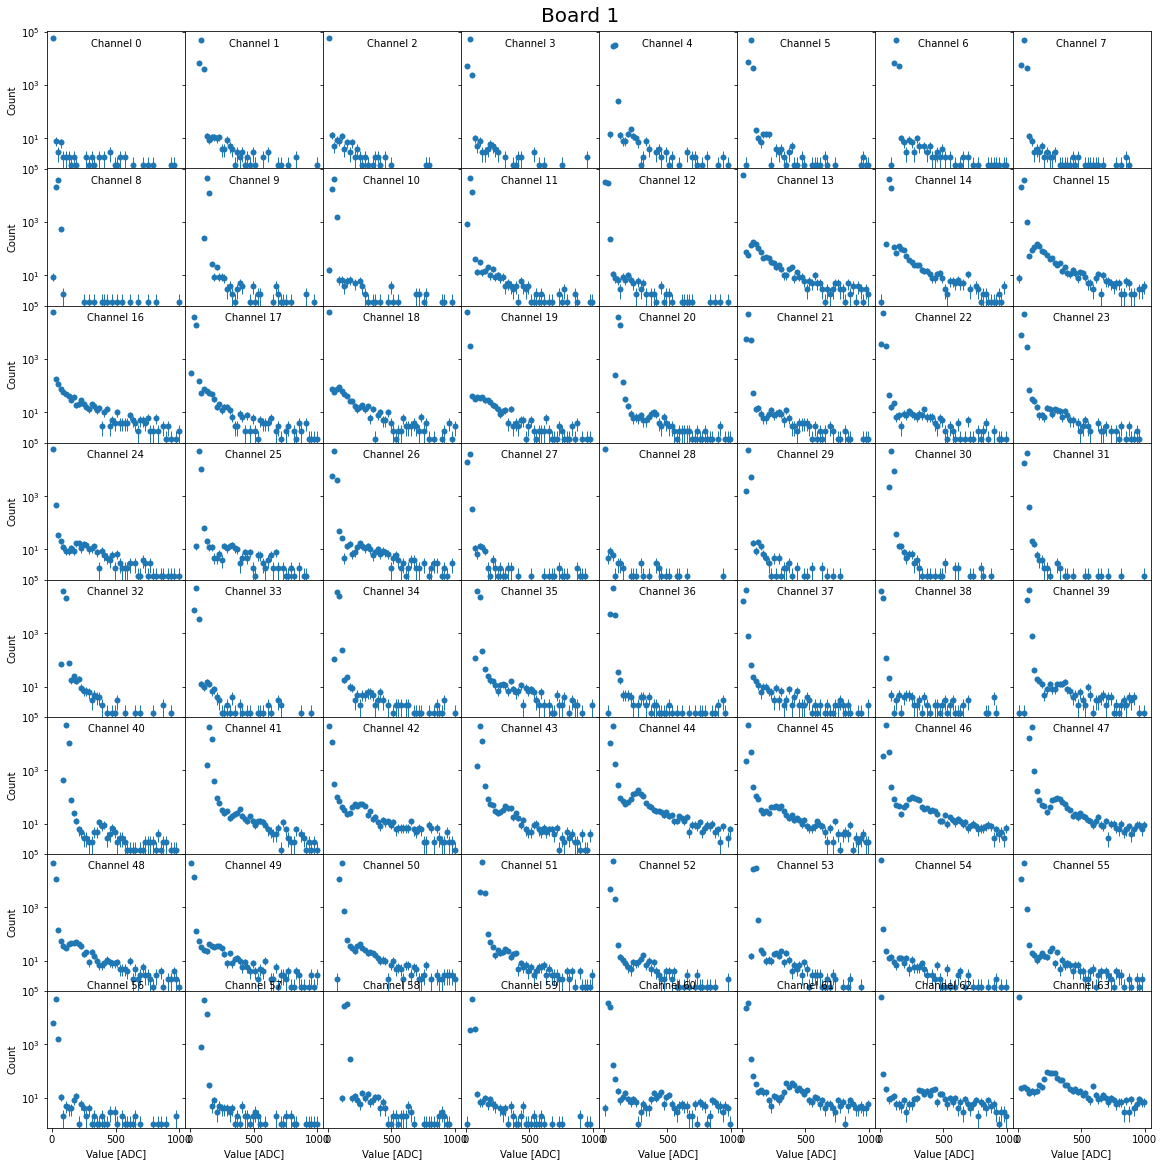

In [10]:
plot_histograms(1, events)

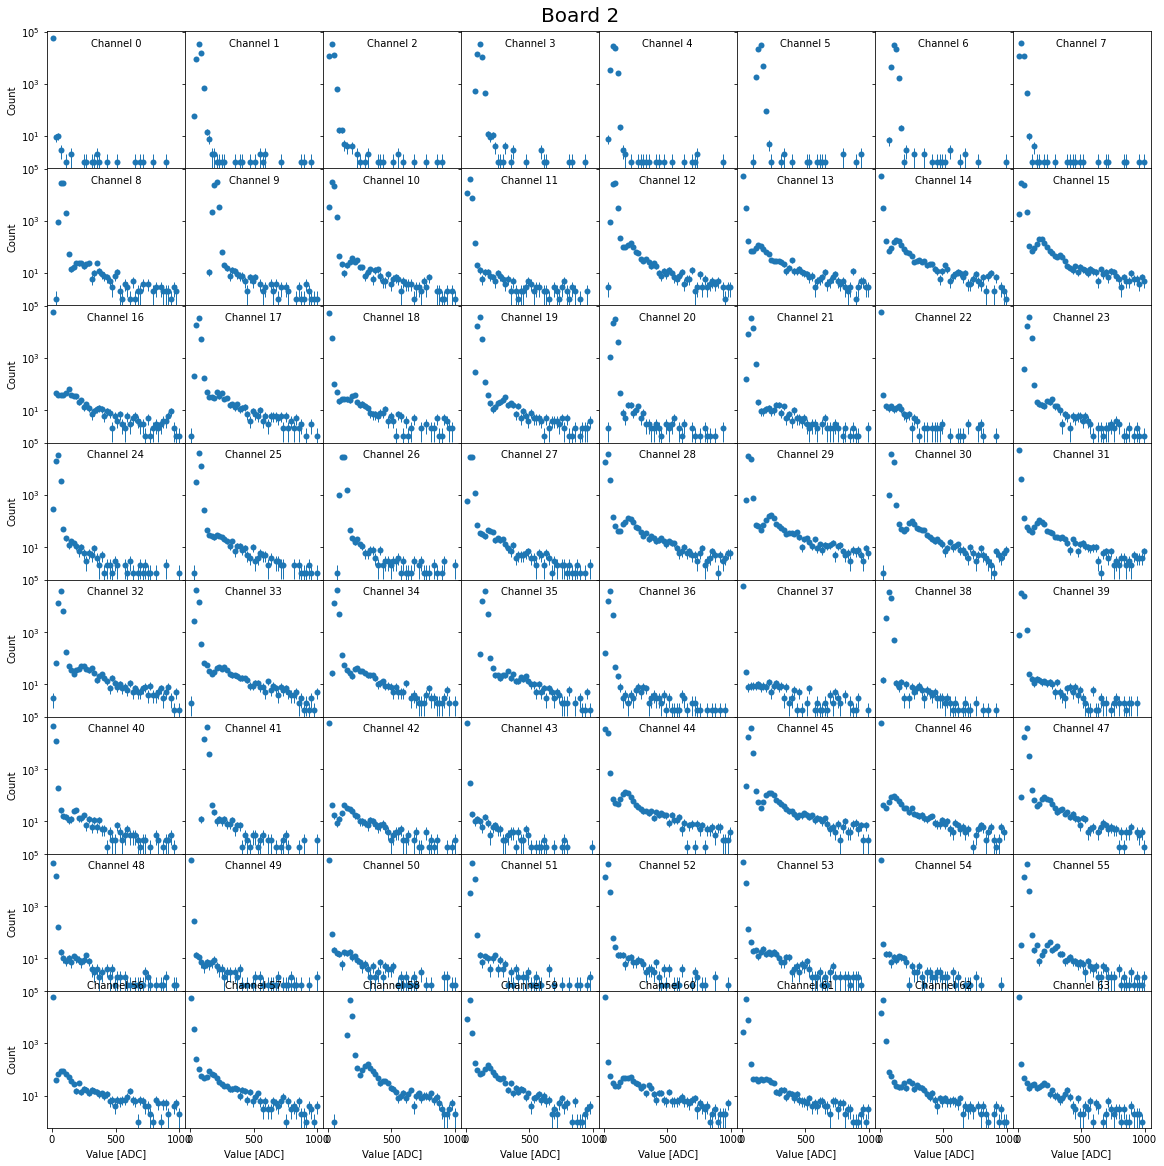

In [11]:
plot_histograms(2, events)